In [21]:
import GPy
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [39]:
df = pd.read_pickle('Random-var-all.pickl')


In [40]:
df.head(2)

,completed,config_sha1,elapsed,host,id,mean_test_score,mean_train_score,n_test_samples,n_train_samples,parameters,project_name,started,status,test_scores,traceback,train_scores,user,strategy
0,2017-08-18 20:16:49.812477,8fd40cd83d5f530a53c05fada83967b19a248199,1970-01-01 00:07:29.210559,compute308.bc4.acrc.priv,1,2.842569,2.996021,"[200000, 200000, 200000, 200000, 200000]","[200000, 200000, 200000, 200000, 200000]","{'cluster__random_state': None, 'cluster__n_in...",alpha_angle,2017-08-18 20:09:20.601918,SUCCEEDED,"[2.977152429810875, 2.9909674944247566, 2.9662...",None,"[2.988860204149737, 2.9987766501032995, 2.9960...",ra15808,fixed
1,2017-08-18 20:54:14.571878,8fd40cd83d5f530a53c05fada83967b19a248199,1970-01-01 00:44:53.918217,compute308.bc4.acrc.priv,2,2.954952,2.997943,"[200000, 200000, 200000, 200000, 200000]","[200000, 200000, 200000, 200000, 200000]","{'cluster__random_state': None, 'cluster__n_in...",alpha_angle,2017-08-18 20:09:20.653661,SUCCEEDED,"[2.953804573511941, 2.946792661204334, 2.97513...",None,"[2.9998938576712026, 2.9995053860291425, 2.999...",ra15808,fixed


In [41]:
# extract params
params = ['tica__lag_time', 'tica__n_components', 'cluster__n_clusters', 'variance_cut__threshold' ]
for param in params:
    df[param.split('__')[-1]] = df['parameters'].apply(lambda x: x[param])

In [42]:
# calculate error
df['test_error'] = df['test_scores'].apply(lambda x: np.array(x).std())

In [43]:
df['test_mean'] = df['test_scores'].apply(lambda x: np.array(x).mean())

In [44]:
df.rename(columns={'project_name': 'feature'}, inplace=True)
df = df.loc[:, ['id','feature','strategy',  'test_mean', 'test_error', 'lag_time', 'n_components',  'n_clusters', 'threshold']]


In [45]:
print(df.shape)
df.dropna(how='any', inplace=True)
print(df.shape)

(6819, 9)
(6819, 9)


In [46]:
# Test/training split
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler

cv = ShuffleSplit(n_splits=5, test_size=0.5, random_state=42)
scaler = MinMaxScaler(feature_range=(0,1))

## Homoscedastic GP regresssion

### The kernels

## The features

In [10]:
features = df['feature'].unique()
kernels = ['RBF', 'RBF_sum', 'M52', 'M52_sum', 'M32', 'M32_sum', 'Exp', 'Exp_sum']

### Optimize the models

In [11]:
mean_square_errors = []
mean_standard_log_losses = []
kernel = []
strategy = []
feature = []

strat = 'fixed'
params = ['lag_time','n_components', 'n_clusters', 'threshold']
log_params_idx = [0, 3]
for feat in features:
    # Get data        
    idx = (df['strategy']==strat) & (df['feature']==feat)
    X = df.loc[idx, params].values
    y = df.loc[idx, 'test_mean'].values[:, None]

    # Log transforms
    for log_idx in log_params_idx:
        X[:, log_idx] = np.log(X[:, log_idx])

    # Scale to [0,1]
    Xs = scaler.fit_transform(X) 
    
    # Only select some of the data: 
#     Xs_tr, Xs_te, y_tr, y_te = train_test_split(Xs, y, test_size=0.4)
    
    for kern_name in kernels:
        
        n_dims = Xs.shape[1]
        noise = GPy.kern.White(input_dim=n_dims)  
        if kern_name=='RBF':
            kern = GPy.kern.RBF(input_dim=n_dims, ARD=True) + noise
        elif kern_name=='RBF_sum':
            kern = np.sum([GPy.kern.RBF(input_dim=1, active_dims=[i]) for i in range(n_dims)]) + noise
        elif kern_name=='M52':
            kern = GPy.kern.Matern52(input_dim=n_dims, ARD=True) + noise  
        elif kern_name=='M52_sum':
            kern = np.sum([GPy.kern.Matern52(input_dim=1, active_dims=[i]) for i in range(n_dims)]) + noise
        elif kern_name=='M32':
            kern = GPy.kern.Matern32(input_dim=n_dims, ARD=True) + noise  
        elif kern_name=='M32_sum':
            kern = np.sum([GPy.kern.Matern32(input_dim=1, active_dims=[i]) for i in range(n_dims)]) + noise  
        elif kern_name=='Exp':
            kern = GPy.kern.Exponential(input_dim=n_dims, ARD=True) + noise        
        elif kern_name=='Exp_sum':
            kern = np.sum([GPy.kern.Exponential(input_dim=1, active_dims=[i]) for i in range(n_dims)]) + noise  
            
        print('Feature: {}'.format(feat))
        print('Kernel: {}'.format(kern_name))
        print(kern)
        
        for train_idx, test_idx in cv.split(Xs):
            
            X_train = Xs[train_idx, :]
            y_train = y[train_idx]
            X_test = Xs[test_idx, :]
            y_test = y[test_idx]
            try:
                m = GPy.models.GPRegression(X_train,y_train,kern)
                m.optimize_restarts(num_restarts=20, verbose=False)                
                mse = np.mean((y_test - m.predict(X_test, kern=None)[0])**2)/y_test.var()
                msll = np.mean(-m.log_predictive_density(X_test, y_test))
            except:
                mse = np.nan
                msll = np.nan
                
            # Record data
            mean_square_errors.append(mse)
            mean_standard_log_losses.append(msll)
            kernel.append(kern_name)
            feature.append(feat)


Feature: alpha_angle
Kernel: RBF
  sum.             |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |   (4,)  |      +ve      |        
  white.variance   |    1.0  |      +ve      |        


 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/kern/src/stationary.py:129: RuntimeWarning:overflow encountered in square
 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/kern/src/stationary.py:130: RuntimeWarning:invalid value encountered in add
 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/paramz-0.7.4-py3.5.egg/paramz/transformations.py:106: RuntimeWarning:invalid value encountered in greater
 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/paramz-0.7.4-py3.5.egg/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater
 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/paramz-0.7.4-py3.5.egg/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1
 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/kern/src/stationary.py:229: RuntimeWarning:invalid value encountered in true_divide
 /Users/robert_arbon/an

Feature: alpha_angle
Kernel: RBF_sum
  sum.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    1.0  |      +ve      |        
  rbf_1.variance     |    1.0  |      +ve      |        
  rbf_1.lengthscale  |    1.0  |      +ve      |        
  rbf_2.variance     |    1.0  |      +ve      |        
  rbf_2.lengthscale  |    1.0  |      +ve      |        
  rbf_3.variance     |    1.0  |      +ve      |        
  rbf_3.lengthscale  |    1.0  |      +ve      |        
  white.variance     |    1.0  |      +ve      |        


 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/kern/src/rbf.py:35: RuntimeWarning:overflow encountered in square


Feature: alpha_angle
Kernel: M52
  sum.               |  value  |  constraints  |  priors
  Mat52.variance     |    1.0  |      +ve      |        
  Mat52.lengthscale  |   (4,)  |      +ve      |        
  white.variance     |    1.0  |      +ve      |        


 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/kern/src/stationary.py:482: RuntimeWarning:invalid value encountered in multiply
 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/kern/src/stationary.py:482: RuntimeWarning:overflow encountered in multiply


Feature: alpha_angle
Kernel: M52_sum
  sum.                 |  value  |  constraints  |  priors
  Mat52.variance       |    1.0  |      +ve      |        
  Mat52.lengthscale    |    1.0  |      +ve      |        
  Mat52_1.variance     |    1.0  |      +ve      |        
  Mat52_1.lengthscale  |    1.0  |      +ve      |        
  Mat52_2.variance     |    1.0  |      +ve      |        
  Mat52_2.lengthscale  |    1.0  |      +ve      |        
  Mat52_3.variance     |    1.0  |      +ve      |        
  Mat52_3.lengthscale  |    1.0  |      +ve      |        
  white.variance       |    1.0  |      +ve      |        


 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/kern/src/stationary.py:482: RuntimeWarning:overflow encountered in square


Feature: alpha_angle
Kernel: M32
  sum.               |  value  |  constraints  |  priors
  Mat32.variance     |    1.0  |      +ve      |        
  Mat32.lengthscale  |   (4,)  |      +ve      |        
  white.variance     |    1.0  |      +ve      |        


 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/kern/src/stationary.py:403: RuntimeWarning:invalid value encountered in multiply


Feature: alpha_angle
Kernel: M32_sum
  sum.                 |  value  |  constraints  |  priors
  Mat32.variance       |    1.0  |      +ve      |        
  Mat32.lengthscale    |    1.0  |      +ve      |        
  Mat32_1.variance     |    1.0  |      +ve      |        
  Mat32_1.lengthscale  |    1.0  |      +ve      |        
  Mat32_2.variance     |    1.0  |      +ve      |        
  Mat32_2.lengthscale  |    1.0  |      +ve      |        
  Mat32_3.variance     |    1.0  |      +ve      |        
  Mat32_3.lengthscale  |    1.0  |      +ve      |        
  white.variance       |    1.0  |      +ve      |        


 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/kern/src/stationary.py:403: RuntimeWarning:overflow encountered in multiply


Feature: alpha_angle
Kernel: Exp
  sum.                     |  value  |  constraints  |  priors
  Exponential.variance     |    1.0  |      +ve      |        
  Exponential.lengthscale  |   (4,)  |      +ve      |        
  white.variance           |    1.0  |      +ve      |        
Feature: alpha_angle
Kernel: Exp_sum
  sum.                       |  value  |  constraints  |  priors
  Exponential.variance       |    1.0  |      +ve      |        
  Exponential.lengthscale    |    1.0  |      +ve      |        
  Exponential_1.variance     |    1.0  |      +ve      |        
  Exponential_1.lengthscale  |    1.0  |      +ve      |        
  Exponential_2.variance     |    1.0  |      +ve      |        
  Exponential_2.lengthscale  |    1.0  |      +ve      |        
  Exponential_3.variance     |    1.0  |      +ve      |        
  Exponential_3.lengthscale  |    1.0  |      +ve      |        
  white.variance             |    1.0  |      +ve      |        
Feature: kappa_angle
Kernel:

 /Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/GPy/likelihoods/gaussian.py:316: RuntimeWarning:invalid value encountered in log


Feature: pp_tor
Kernel: RBF_sum
  sum.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    1.0  |      +ve      |        
  rbf_1.variance     |    1.0  |      +ve      |        
  rbf_1.lengthscale  |    1.0  |      +ve      |        
  rbf_2.variance     |    1.0  |      +ve      |        
  rbf_2.lengthscale  |    1.0  |      +ve      |        
  rbf_3.variance     |    1.0  |      +ve      |        
  rbf_3.lengthscale  |    1.0  |      +ve      |        
  white.variance     |    1.0  |      +ve      |        
Feature: pp_tor
Kernel: M52
  sum.               |  value  |  constraints  |  priors
  Mat52.variance     |    1.0  |      +ve      |        
  Mat52.lengthscale  |   (4,)  |      +ve      |        
  white.variance     |    1.0  |      +ve      |        
Feature: pp_tor
Kernel: M52_sum
  sum.                 |  value  |  constraints  |  priors
  Mat52.variance       |    1.0  |      +ve      | 

In [20]:
results = {'mean_square_errors': mean_square_errors, 
           'mean_standard_log_losses': mean_standard_log_losses, 
           'kernel': kernel, 
           'feature': feature}
results = pd.DataFrame(results)

results.to_pickle('choose_kernel.pickl')

## Calculate the errors

In [3]:
results = pd.read_pickle('choose_kernel.pickl')

In [4]:
results.head()

,feature,kernel,mean_square_errors,mean_standard_log_losses
0,alpha_angle,RBF,0.925916,-1.254870
1,alpha_angle,RBF,0.960716,-1.304776
2,alpha_angle,RBF,0.918523,-1.321636
3,alpha_angle,RBF,0.904104,-1.382038
4,alpha_angle,RBF,0.920807,-1.411672


In [5]:
to_expand=['mean_square_errors', 'mean_standard_log_losses']
df_expanded = []
for col in to_expand:    
    s = results.apply(lambda x: pd.Series(x[col]),axis=1).stack().reset_index(level=1, drop=True)
    s.name=col
    df_expanded.append(pd.DataFrame(s))
    results.drop(labels=col, axis=1, inplace=True)
    
df_expanded = pd.concat(df_expanded, axis=1)

In [6]:
results = results.merge(right=df_expanded, how='inner', right_index=True, left_index=True, sort=True)

In [7]:
results.head()

,feature,kernel,mean_square_errors,mean_standard_log_losses
0,alpha_angle,RBF,0.925916,-1.254870
1,alpha_angle,RBF,0.960716,-1.304776
2,alpha_angle,RBF,0.918523,-1.321636
3,alpha_angle,RBF,0.904104,-1.382038
4,alpha_angle,RBF,0.920807,-1.411672


In [8]:
results = pd.melt(frame=results, id_vars=['feature', 'kernel'], var_name='error_type', value_name='error')

In [9]:
error_types = {'mean_square_errors': 'MSE', 'mean_standard_log_losses': 'MSLL'}
angles = {'alpha_angle': r'$\alpha$', 'kappa_angle': r'$\kappa$', 'phi_tor': r'$\phi$', 
          'omega_tor': r'$\omega$', 'phi-o_tor': r'$\phi-\omega$', 'psi_tor': r'$\psi$', 
          'psi-o_tor': r'$\psi-\omega$', 'pp_tor': r'$\phi-\psi$'}
results['feature_short'] = results['feature'].apply(lambda x: angles[x])

In [10]:
results['error_type'] = results['error_type'].apply(lambda x: error_types[x])

In [11]:
results.head()

,feature,kernel,error_type,error,feature_short
0,alpha_angle,RBF,MSE,0.925916,$\alpha$
1,alpha_angle,RBF,MSE,0.960716,$\alpha$
2,alpha_angle,RBF,MSE,0.918523,$\alpha$
3,alpha_angle,RBF,MSE,0.904104,$\alpha$
4,alpha_angle,RBF,MSE,0.920807,$\alpha$


In [12]:
results['kernel_family'] = results['kernel'].apply(lambda x: x.split('_')[0])

In [13]:
results['kernel_type'] = results['kernel'].apply(lambda x: 'Sum' if len(x.split('_'))>1 else 'ARD')

## Plot Mean Square Error and rankings

In [14]:
mcv_mse = results.loc[results['error_type']=='MSE', 
                      ['feature_short','kernel_family', 'kernel_type', 'error']].groupby(
                        ['feature_short', 'kernel_family', 'kernel_type']).aggregate(np.mean)

In [15]:
mcv_mse_ranked = mcv_mse.groupby(['feature_short']).rank(ascending=True)

In [16]:
mcv_mse_ranked.reset_index(inplace=True)

In [17]:
mcv_mse_ranked.rename(columns={'error': 'rank'}, inplace=True)

In [18]:
mcv_mse_median_rank = mcv_mse_ranked.groupby(['kernel_family', 'kernel_type']).aggregate(np.median)

In [22]:
families = mcv_mse_ranked['kernel_family'].unique()
swarm_cols = dict(zip(families, ['k']*len(families)))


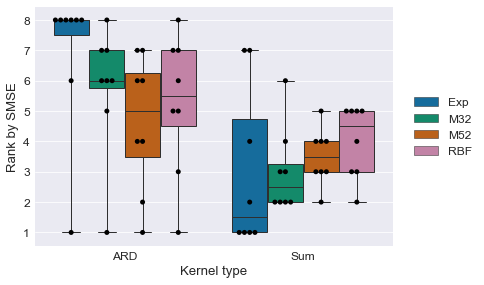

In [23]:
# swarm_cols = dict(zi)
with sns.plotting_context('paper', font_scale=1.5):
    sns.set_palette('colorblind')
    ax = sns.swarmplot(x='kernel_type', y='rank', hue='kernel_family', data=mcv_mse_ranked, palette=swarm_cols, 
                  split=True)
    ax = sns.boxplot(x='kernel_type', y='rank',hue='kernel_family', data=mcv_mse_ranked, whis=20, linewidth=1, ax=ax)
    handels, labels = ax.get_legend_handles_labels()
    ax.legend(handels[:4], labels[:4], bbox_to_anchor=(1.01, 0.5), loc='center', bbox_transform=plt.gcf().transFigure)
    ax.set_ylabel('Rank by SMSE')
    ax.set_xlabel('Kernel type')
plt.savefig('figures/GMRQ2_kernel_mse_rank.pdf')
plt.savefig('figures/GMRQ2_kernel_mse_rank.png')

In [24]:
results.head()

,feature,kernel,error_type,error,feature_short,kernel_family,kernel_type
0,alpha_angle,RBF,MSE,0.925916,$\alpha$,RBF,ARD
1,alpha_angle,RBF,MSE,0.960716,$\alpha$,RBF,ARD
2,alpha_angle,RBF,MSE,0.918523,$\alpha$,RBF,ARD
3,alpha_angle,RBF,MSE,0.904104,$\alpha$,RBF,ARD
4,alpha_angle,RBF,MSE,0.920807,$\alpha$,RBF,ARD


In [25]:
results['feature_short'].unique()
feat_order = ['$\\alpha$', '$\\kappa$', '$\\phi$', '$\\psi$', '$\\omega$', '$\\phi-\\psi$', '$\\phi-\\omega$',  '$\\psi-\\omega$']

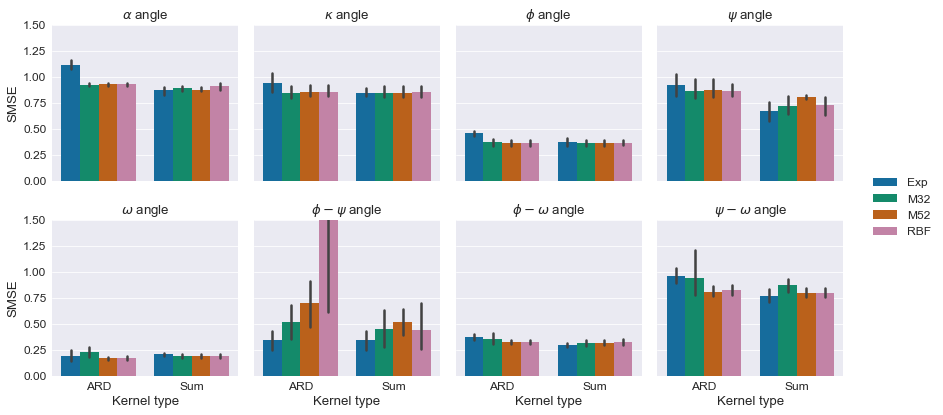

In [26]:
mse = results.loc[results['error_type']=='MSE', :]
mse = mse.sort_values(by=['kernel_family', 'kernel_type'])
with sns.plotting_context('paper', font_scale=1.5):
#     sns.set_palette('colorblind')
    ax = sns.FacetGrid(col='feature_short', col_wrap=4,  data=mse, col_order=feat_order, sharey=True)
    ax.map(sns.barplot, 'kernel_type', 'error', 'kernel_family', palette='colorblind')
    ax.set(ylim=(0,1.5))
    ax.axes[-1].legend(bbox_to_anchor=(1.05, 0.5), loc='center', bbox_transform=ax.fig.transFigure)
    ax.set_axis_labels('Kernel type', 'SMSE')
    ax.set_titles("{col_name} angle")
plt.savefig('figures/GMRQ2_kernel_mse.pdf')
plt.savefig('figures/GMRQ2_kernel_mse.png')

## Plot mean standard log loss and rankings

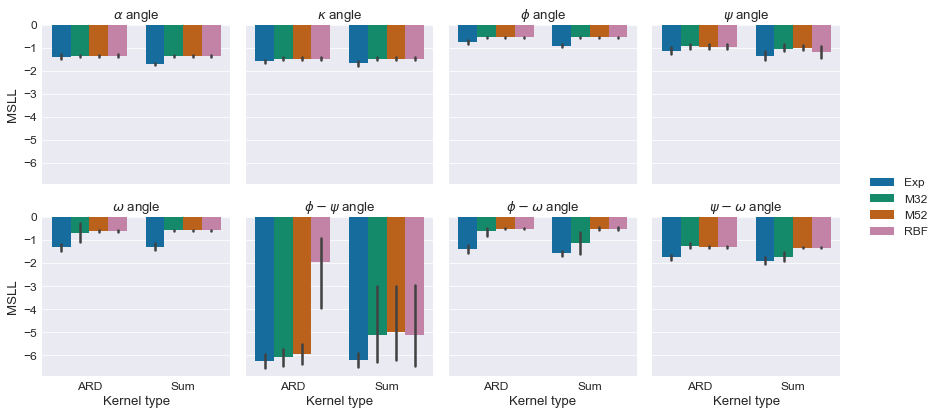

In [27]:
msll = results.loc[results['error_type']=='MSLL', :]
msll = msll.sort_values(by=['kernel_family', 'kernel_type'])
with sns.plotting_context('paper', font_scale=1.5):
#     sns.set_palette('colorblind')
    ax = sns.FacetGrid(col='feature_short', col_wrap=4,  data=msll, col_order=feat_order)
    ax.map(sns.barplot, 'kernel_type', 'error', 'kernel_family', palette='colorblind')
#     ax.set(ylim=(0,1.5))
    ax.axes[-1].legend(bbox_to_anchor=(1.05, 0.5), loc='center', bbox_transform=ax.fig.transFigure)
    ax.set_axis_labels('Kernel type', 'MSLL')
    ax.set_titles("{col_name} angle")
plt.savefig('figures/kernel_msll.pdf')
plt.savefig('figures/kernel_msll.png')

In [28]:
mcv_msll = results.loc[results['error_type']=='MSLL', 
                      ['feature_short','kernel_family', 'kernel_type', 'error']].groupby(
                        ['feature_short', 'kernel_family', 'kernel_type']).aggregate(np.mean)

In [29]:
mcv_msll_ranked = mcv_msll.groupby(['feature_short']).rank(ascending=True)

In [30]:
mcv_msll_ranked.reset_index(inplace=True)

In [31]:
mcv_msll_ranked.rename(columns={'error': 'rank'}, inplace=True)

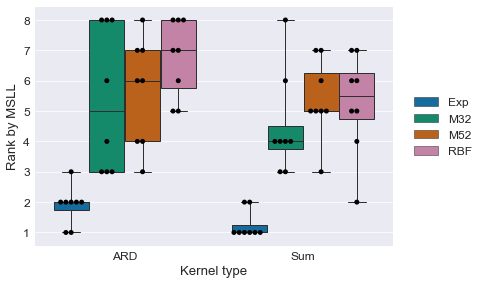

In [32]:
# swarm_cols = dict(zi)
with sns.plotting_context('paper', font_scale=1.5):
    sns.set_palette('colorblind')
    ax = sns.swarmplot(x='kernel_type', y='rank', hue='kernel_family', data=mcv_msll_ranked, palette=swarm_cols, 
                  split=True)
    ax = sns.boxplot(x='kernel_type', y='rank',hue='kernel_family', data=mcv_msll_ranked, whis=20, linewidth=1, ax=ax)
    handels, labels = ax.get_legend_handles_labels()
    ax.legend(handels[:4], labels[:4], bbox_to_anchor=(1.01, 0.5), loc='center', bbox_transform=plt.gcf().transFigure)
    ax.set_ylabel('Rank by MSLL')
    ax.set_xlabel('Kernel type')
plt.savefig('figures/kernel_msll_rank.pdf')
plt.savefig('figures/kernel_msll_rank.png')

## Fit and find maximum of best model

### Get data

In [47]:
strat = 'fixed'
feat = 'alpha_angle'

params = ['lag_time','n_components', 'n_clusters', 'threshold']
log_params_idx = [0, 3]

# Get data        
idx = (df['strategy']==strat) & (df['feature']==feat)
X = df.loc[idx, params].values
y = df.loc[idx, 'test_mean'].values[:, None]

# Log transforms
for log_idx in log_params_idx:
    X[:, log_idx] = np.log(X[:, log_idx])

# Scale to [0,1]
Xs = scaler.fit_transform(X) 



In [51]:
### Specify kernel

In [61]:
n_dims = Xs.shape[1]
noise = GPy.kern.White(input_dim=n_dims) 
kern = np.sum([GPy.kern.Exponential(input_dim=1, active_dims=[i]) for i in range(n_dims)]) + noise  



In [62]:
### Fit model

In [63]:
m = GPy.models.GPRegression(Xs,y,kern)
m.optimize_restarts(num_restarts=5, verbose=True) 

Optimization restart 1/5, f = -608.9840821566892
Optimization restart 2/5, f = -610.3610001038018
Optimization restart 3/5, f = -704.1319558077507
Optimization restart 4/5, f = -566.7092489475269
Optimization restart 5/5, f = -610.3613473969797


In [53]:
### Find maximum of model

In [64]:
m

GP_regression.,value,constraints,priors
sum.Exponential.variance,5.56268464627e-309,+ve,
sum.Exponential.lengthscale,5031.6082549,+ve,
sum.Exponential_1.variance,6.7555675285,+ve,
sum.Exponential_1.lengthscale,1762.80673749,+ve,
sum.Exponential_2.variance,1.78882049892,+ve,
sum.Exponential_2.lengthscale,3834.33939293,+ve,
sum.Exponential_3.variance,0.00333630132547,+ve,
sum.Exponential_3.lengthscale,1.38920248655e-94,+ve,
sum.white.variance,5.56268464627e-309,+ve,
Gaussian_noise.variance,5.56268464627e-309,+ve,


In [75]:
X_start = np.random.random(4)[None, :]
print(X_start)
y_mean, y_var = m.predict(X_start)
y_mean

[[ 0.86650101  0.86107906  0.91779839  0.61936969]]


array([[ 2.90026128]])

In [82]:
from scipy.optimize import minimize

def z(x):
    x = x[None, :]
    y_mean, y_var = m.predict(x)
    return y_mean

y_trials = []
X_trials = []
for i in range(100):
    init = np.random.random(n_dims)[ None, :]
    res = minimize(z, init, bounds=n_dims*[(0., 1.)],
                            options={'maxiter': int(1e3), 'disp': 0})
    y_trials.append(res.fun)
    X_trials.append(res.x)
    
    

In [86]:
y_trials = np.array([x[0][0] for x in y_trials])

In [88]:
idx = np.argmax(y_trials)
X_trials[idx]


array([ 0.42106887,  0.88888892,  0.30561224,  0.0127447 ])